# Set Environment

In [1]:
!nvidia-smi

Mon Oct 30 10:51:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [3]:
print( f"Python {sys.version}\n" )
print( f"NumPy {np.__version__}\n" )
%matplotlib inline
print(f'The scikit-learn version is {sklearn.__version__}')
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

NumPy 1.23.5

The scikit-learn version is 1.2.2
TensorFlow 2.14.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# Generate npy Dataset

In [4]:
!git clone https://github.com/Napasakon/DADS7202_CNN_Image_Classifier.git
!unzip -o /content/DADS7202_CNN_Image_Classifier/dataset.zip -d /content/DADS7202_CNN_Image_Classifier/

Cloning into 'DADS7202_CNN_Image_Classifier'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 5), reused 4 (delta 1), pack-reused 0
Receiving objects: 100% (21/21), 18.38 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Archive:  /content/DADS7202_CNN_Image_Classifier/dataset.zip
   creating: /content/DADS7202_CNN_Image_Classifier/sepak trakaw/
  inflating: /content/DADS7202_CNN_Image_Classifier/__MACOSX/._sepak trakaw  
  inflating: /content/DADS7202_CNN_Image_Classifier/sepak trakaw/IMG (91).jpg  
  inflating: /content/DADS7202_CNN_Image_Classifier/__MACOSX/sepak trakaw/._IMG (91).jpg  
  inflating: /content/DADS7202_CNN_Image_Classifier/sepak trakaw/IMG (29).jpg  
  inflating: /content/DADS7202_CNN_Image_Classifier/__MACOSX/sepak trakaw/._IMG (29).jpg  
  inflating: /content/DADS7202_CNN_Image_Classifier/sepak trakaw/IMG (68).jpg  
  inflating: /content/DADS720

In [5]:
def generate_npy_dataset(srcPath, desPath, imgSize=(224,224), outName='out', classNo=1):
  arr = os.listdir(srcPath)
  x = []
  y = []

  for filename in arr:
      file_destination = srcPath + filename

      img = cv2.imread(file_destination)
      RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(RGB_img, imgSize)
      x.append(img)
      y.append(classNo)
  np.save(desPath + 'x_' + outName, x)
  np.save(desPath + 'y_' + outName, y)

In [6]:
generate_npy_dataset(srcPath='/content/DADS7202_CNN_Image_Classifier/sepak trakaw/',
                    desPath='/content/DADS7202_CNN_Image_Classifier/',
                     imgSize=(224,224),
                     outName='sepak_trakaw',
                     classNo=0)

In [7]:
generate_npy_dataset(srcPath='/content/DADS7202_CNN_Image_Classifier/kendo/',
                    desPath='/content/DADS7202_CNN_Image_Classifier/',
                     imgSize=(224,224),
                     outName='kendo',
                     classNo=1)

In [8]:
generate_npy_dataset(srcPath='/content/DADS7202_CNN_Image_Classifier/handball/',
                    desPath='/content/DADS7202_CNN_Image_Classifier/',
                     imgSize=(224,224),
                     outName='handball',
                     classNo=2)

# Load Data

In [9]:
x0 = np.load('/content/DADS7202_CNN_Image_Classifier/x_sepak_trakaw.npy')
x1 = np.load('/content/DADS7202_CNN_Image_Classifier/x_kendo.npy')
x2 = np.load('/content/DADS7202_CNN_Image_Classifier/x_handball.npy')

print(x0.shape)
print(x1.shape)
print(x2.shape)

(125, 224, 224, 3)
(140, 224, 224, 3)
(130, 224, 224, 3)


In [10]:
y0 = np.load('/content/DADS7202_CNN_Image_Classifier/y_sepak_trakaw.npy')
y1 = np.load('/content/DADS7202_CNN_Image_Classifier/y_kendo.npy')
y2 = np.load('/content/DADS7202_CNN_Image_Classifier/y_handball.npy')

print(y0.shape)
print(y1.shape)
print(y2.shape)

(125,)
(140,)
(130,)


In [11]:
x = np.concatenate((x0, x1, x2))
y = np.concatenate((y0, y1, y2))
print(x.shape)
print(y.shape)

(395, 224, 224, 3)
(395,)


In [12]:
#Train Test Split
from sklearn.model_selection import train_test_split

test_size = 0.3
x_train, x_test = train_test_split(x, test_size = test_size, random_state = 3)
y_train, y_test = train_test_split(y, test_size = test_size, random_state = 3)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(276, 224, 224, 3)
(276,)
(119, 224, 224, 3)
(119,)


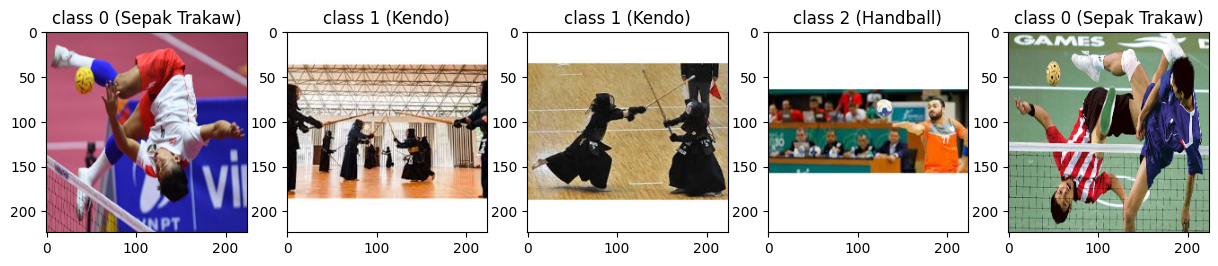

In [13]:
#visualize the first 5 image of x_train
label = ['Sepak Trakaw','Kendo','Handball']
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_train[i]} ({label[y_train[i]]})')
  plt.imshow(x_train[i])
plt.show()

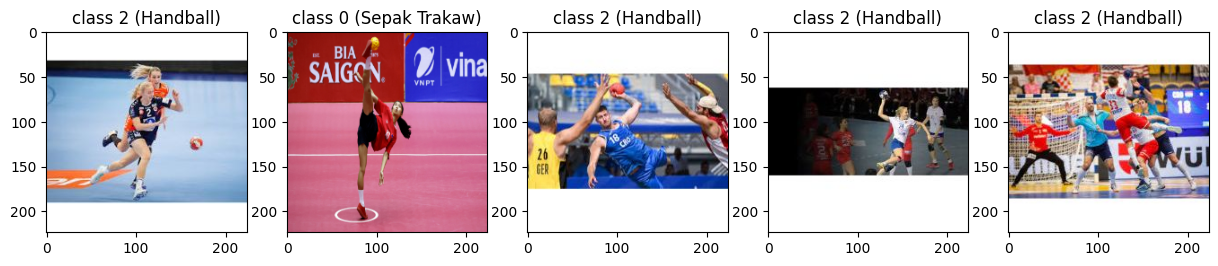

In [14]:
#visualize the first 5 image of x_test
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_test[i]} ({label[y_test[i]]})')
  plt.imshow(x_test[i])
plt.show()

# Prepare Model

In [15]:
#Load XCEPTION model
xc_extractor = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
xc_extractor.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [16]:
#Pre-processing
x_train_xc = tf.keras.applications.xception.preprocess_input(x_train)
x_test_xc = tf.keras.applications.xception.preprocess_input(x_test)

print(x_train_xc.shape)
print(x_test_xc.shape)

(276, 224, 224, 3)
(119, 224, 224, 3)


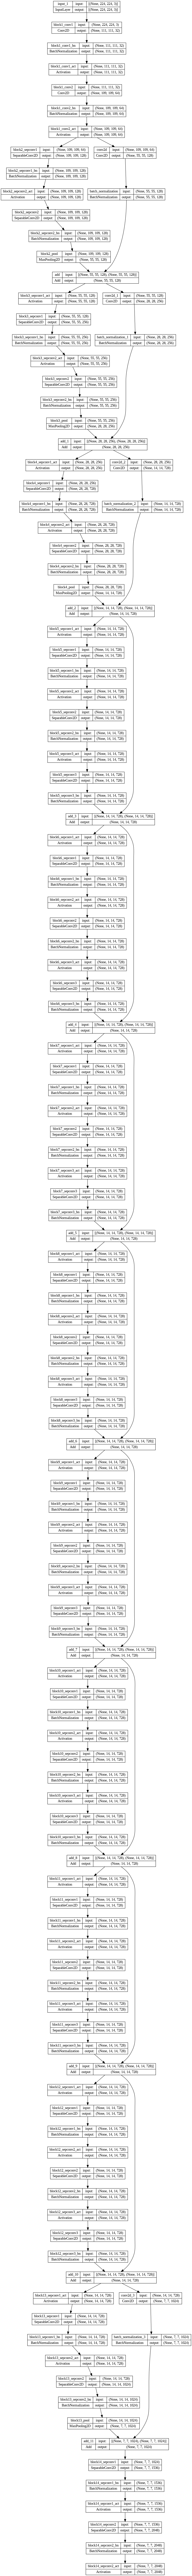

In [17]:
# plot model
tf.keras.utils.plot_model(xc_extractor, to_file = 'xc_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

# Fine-Tune

In [18]:
#Recursively freeze all layers in the model first
xc_extractor.trainable = False

#Access a layer by 0-based index
a = xc_extractor.layers[106:115]
for i in a:
 i.trainable=True

b = xc_extractor.layers[117:122]
for i in b:
 i.trainable=True

c = xc_extractor.layers[126:132]
for i in c:
 i.trainable=True

In [19]:
#Iterate over all layers in the model
for i, layer in enumerate(xc_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv1_bn, Trainable = False
Layer 3: Name = block1_conv1_act, Trainable = False
Layer 4: Name = block1_conv2, Trainable = False
Layer 5: Name = block1_conv2_bn, Trainable = False
Layer 6: Name = block1_conv2_act, Trainable = False
Layer 7: Name = block2_sepconv1, Trainable = False
Layer 8: Name = block2_sepconv1_bn, Trainable = False
Layer 9: Name = block2_sepconv2_act, Trainable = False
Layer 10: Name = block2_sepconv2, Trainable = False
Layer 11: Name = block2_sepconv2_bn, Trainable = False
Layer 12: Name = conv2d, Trainable = False
Layer 13: Name = block2_pool, Trainable = False
Layer 14: Name = batch_normalization, Trainable = False
Layer 15: Name = add, Trainable = False
Layer 16: Name = block3_sepconv1_act, Trainable = False
Layer 17: Name = block3_sepconv1, Trainable = False
Layer 18: Name = block3_sepconv1_bn, Trainable = False
Layer 19: Name = block3_sepconv2_act, 

# Data Augmentation

In [20]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1. / 255,
        #featurewise_center=True,
        samplewise_center=True,
        #featurewise_std_normalization=True,
        samplewise_std_normalization=True,
        #zca_whitening=False,
        rotation_range=0,
        width_shift_range=5.0,
        height_shift_range=5.0,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.3)
train_datagen.fit(x_train_xc,seed=123)

In [21]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1. / 255,
        #featurewise_center=True,
        samplewise_center=True,
        #featurewise_std_normalization=True,
        samplewise_std_normalization=True
        )
test_datagen.fit(x_test_xc,seed=123)

===== Train batch no. 1/1 =====


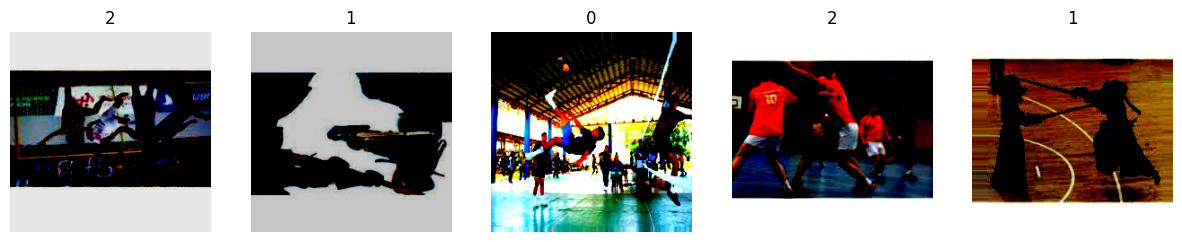

In [22]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train_xc, y_train, batch_size=5, subset='training' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks
  plt.show()

  if b+1 >= n_show:
    break

===== Train batch no. 1/1 =====


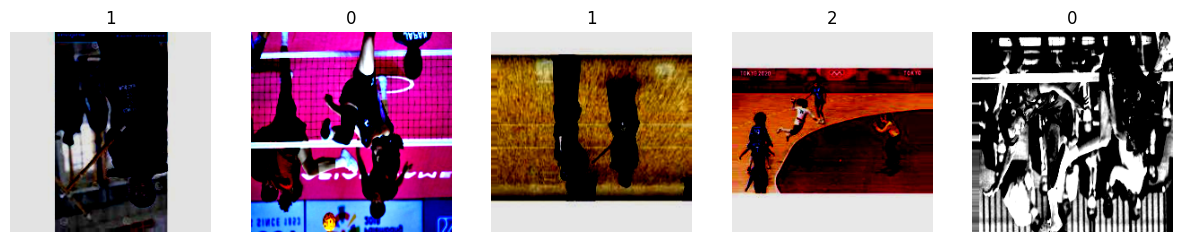

In [23]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train_xc, y_train, batch_size=5, subset='validation' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks
  plt.show()

  if b+1 >= n_show:
    break

===== Train batch no. 1/1 =====


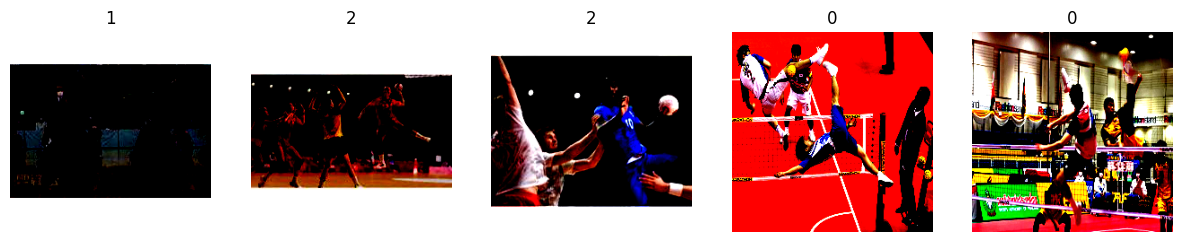

In [24]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( test_datagen.flow( x_test_xc,y_test,batch_size=5 ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks
  plt.show()

  if b+1 >= n_show:
    break

# Train Model

In [25]:
x = xc_extractor.output

#Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x= tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(3, activation = 'softmax')(x)

#construct the main model
model = tf.keras.models.Model(inputs = xc_extractor.inputs, outputs = new_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

In [26]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) ,
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['acc']
                     )

In [27]:
checkpoint_filepath = "bestweights.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_acc',
                                                                mode='max',
                                                                save_best_only=True)

In [28]:
history = model.fit(train_datagen.flow(x_train_xc ,y_train,batch_size=64,subset='training',seed=123,shuffle=False),epochs = 30, verbose = 2,
                    callbacks=[model_checkpoint_callback],
                    validation_data=train_datagen.flow(x_train_xc ,y_train,subset='validation',seed=123,shuffle=False))

Epoch 1/30
4/4 - 32s - loss: 1.1858 - acc: 0.5567 - val_loss: 14.3925 - val_acc: 0.3049 - 32s/epoch - 8s/step
Epoch 2/30
4/4 - 6s - loss: 0.5846 - acc: 0.7577 - val_loss: 1.7437 - val_acc: 0.7927 - 6s/epoch - 1s/step
Epoch 3/30
4/4 - 5s - loss: 0.3016 - acc: 0.8918 - val_loss: 1.4144 - val_acc: 0.8049 - 5s/epoch - 1s/step
Epoch 4/30
4/4 - 4s - loss: 0.1830 - acc: 0.9381 - val_loss: 2.0900 - val_acc: 0.7805 - 4s/epoch - 973ms/step
Epoch 5/30
4/4 - 5s - loss: 0.1983 - acc: 0.9433 - val_loss: 0.9588 - val_acc: 0.9146 - 5s/epoch - 1s/step
Epoch 6/30
4/4 - 4s - loss: 0.0809 - acc: 0.9742 - val_loss: 0.5451 - val_acc: 0.9146 - 4s/epoch - 946ms/step
Epoch 7/30
4/4 - 6s - loss: 0.0389 - acc: 0.9897 - val_loss: 0.6259 - val_acc: 0.9390 - 6s/epoch - 1s/step
Epoch 8/30
4/4 - 4s - loss: 0.0764 - acc: 0.9742 - val_loss: 0.9394 - val_acc: 0.8659 - 4s/epoch - 944ms/step
Epoch 9/30
4/4 - 9s - loss: 0.0353 - acc: 0.9948 - val_loss: 1.0957 - val_acc: 0.9390 - 9s/epoch - 2s/step
Epoch 10/30
4/4 - 4s - lo

# Model Evaluate

In [29]:
model.load_weights("bestweights.hdf5")
results = model.evaluate(test_datagen.flow(x_test_xc, y_test,batch_size=128,seed=123,shuffle=False))
print(f'{model.metrics_names}: {results}')

1/1 [==============================] - 6s 6s/step - loss: 0.2281 - acc: 0.9832
['loss', 'acc']: [0.22814027965068817, 0.9831932783126831]


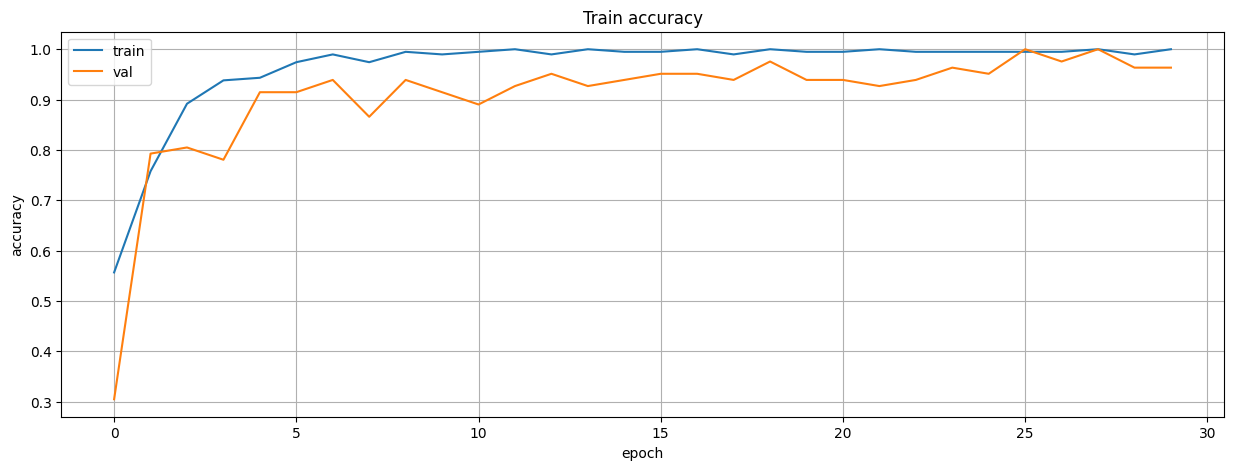

In [30]:
#Summarize history of accuracy
plt.figure(figsize = (15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

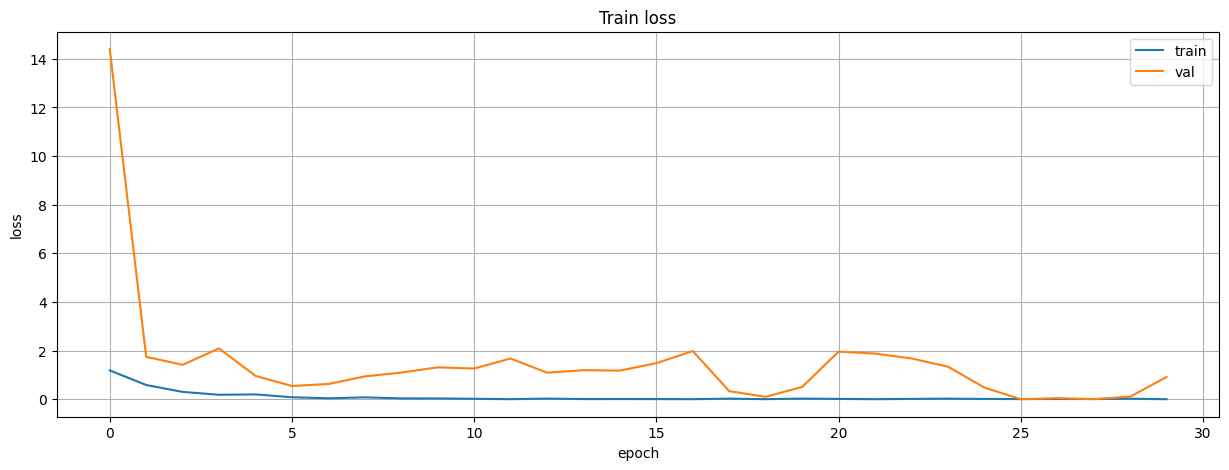

In [31]:
#Summarize history for loss
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

1/1 [==============================] - 0s 22ms/step


[Text(0.5, 23.52222222222222, 'Predict'),
 Text(50.72222222222221, 0.5, 'Actual')]

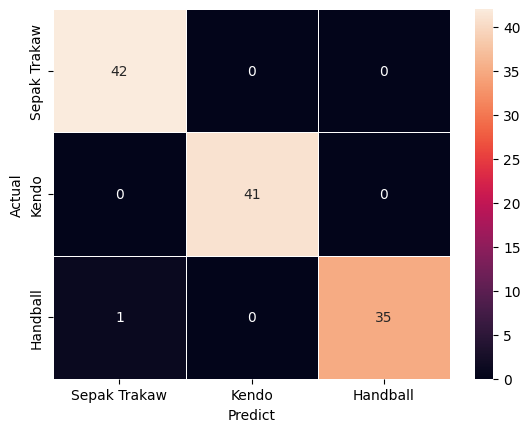

In [32]:
y_pred = []
for i in range(len(x_test_xc)):
  x_input = x_test_xc[i][np.newaxis, ...]
  y_pred.append(np.argmax(model.predict(x_input)))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot = True, xticklabels = label, yticklabels = label, linewidth=.5, )
ax.set(xlabel='Predict',ylabel='Actual')

In [33]:
# for i in range(len(x_test_xc)):
#   y_pred = model.predict(x_test_xc[i].reshape(1,224,224,3))
#   if np.argmax(y_pred) != y_test[i] and y_test[i]==0:
#     plt.imshow(x_test[i])
#     plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
#     plt.show()
#   else:
#     continue

1/1 [==============================] - 0s 24ms/step


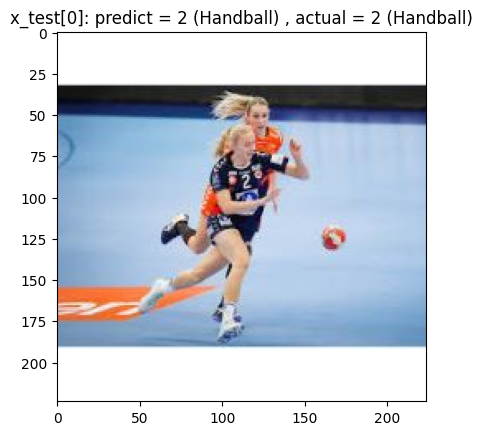

1/1 [==============================] - 0s 21ms/step


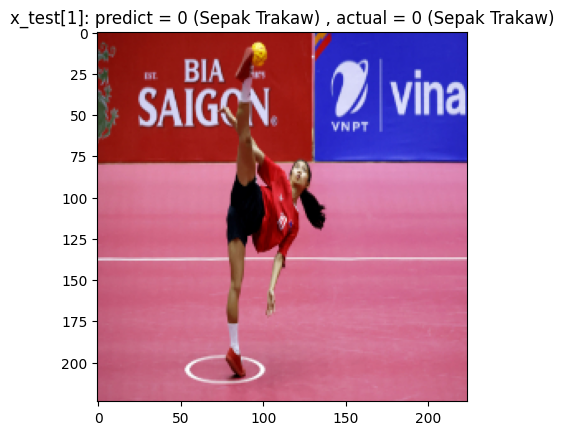

1/1 [==============================] - 0s 33ms/step


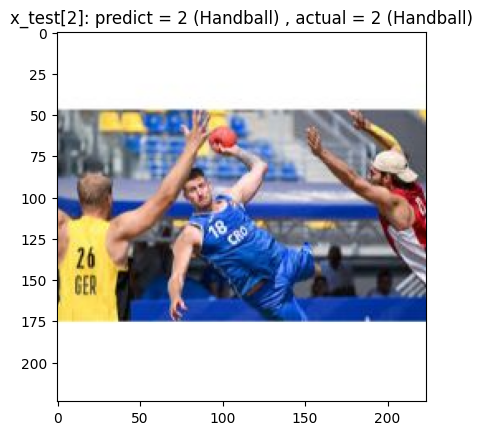

1/1 [==============================] - 0s 32ms/step


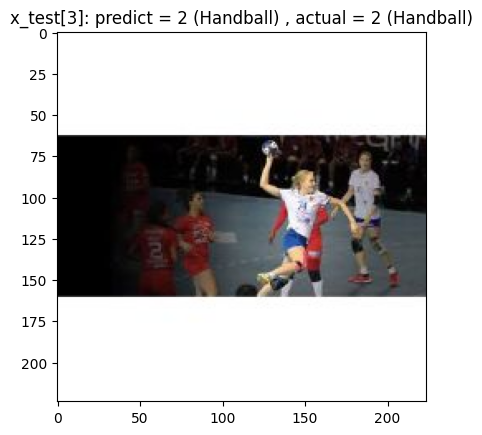

1/1 [==============================] - 0s 23ms/step


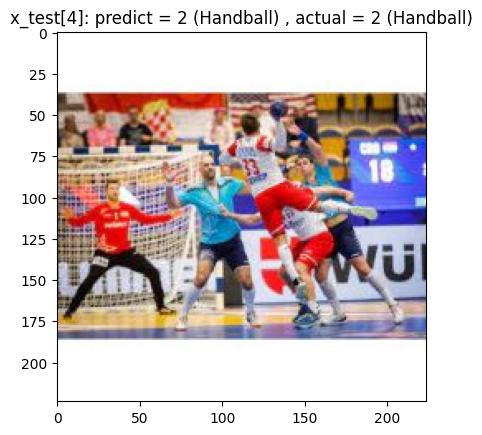

In [34]:
for i in range(5):
  y_pred = model.predict(x_test_xc[i].reshape(1,224,224,3))
  plt.imshow(x_test[i])
  plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
  plt.show()

# Grad-Cam

In [35]:
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
last_conv_layer_name = "block14_sepconv2_act"

In [36]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [37]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = cmp.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)

      # Display Grad CAM
      display(Image(cam_path))

1/1 [==============================] - 0s 107ms/step
Predicted: Handball | Actual: Handball 


<ipython-input-37-eb3ca1d60376>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cmp.get_cmap("jet")


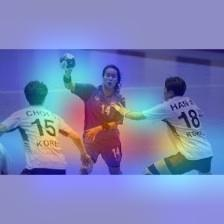

1/1 [==============================] - 0s 50ms/step
Predicted: Sepak Trakaw | Actual: Sepak Trakaw 


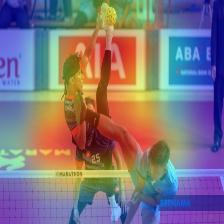

1/1 [==============================] - 0s 110ms/step
Predicted: Kendo | Actual: Kendo 


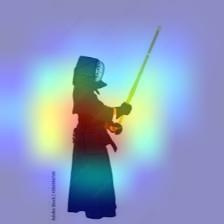

1/1 [==============================] - 0s 60ms/step
Predicted: Kendo | Actual: Kendo 


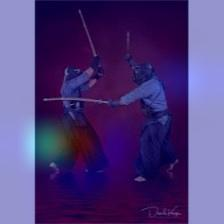

1/1 [==============================] - 0s 49ms/step
Predicted: Handball | Actual: Handball 


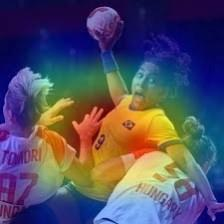

In [39]:
for i in range(5):
  c= np.random.randint(0,119)
  img_path = x_test[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,224,224,3))
  print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)